# WASP-127b: Fitting LCs and RVs

In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN
import matplotlib.pyplot as plt
import pandas as pd
CONAN.__version__

'3.3.11'

We start by getting the data for the analysis. `TESS` has observed transits of **WASP-127b** in many sectors. There are also transits AND RV observations by `EULERCAM` AND `CORALIE` on the Swiss telescope.

### Download TESS data

using the `lightkurve` package, `CONAN` allows you to query the MAST database and download TESS data

In [2]:
from CONAN.get_files import get_TESS_data

df = get_TESS_data("WASP-127")
df.search() 

SearchResult containing 25 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 09 2019              SPOC     120   169226822      0.0
  1 TESS Sector 35 2021              SPOC      20   169226822      0.0
  2 TESS Sector 46 2021              SPOC     120   169226822      0.0
  3 TESS Sector 35 2021              SPOC     120   169226822      0.0
  4 TESS Sector 72 2023              SPOC      20   169226822      0.0
  5 TESS Sector 62 2023              SPOC      20   169226822      0.0
  6 TESS Sector 72 2023              SPOC     120   169226822      0.0
  7 TESS Sector 62 2023              SPOC     120   169226822      0.0
  8 TESS Sector 89 2025              SPOC      20   169226822      0.0
...            ...  ...               ...     ...         ...      ...
 15 TESS Sector 09 2019           

Let's go with long cadence (600s) data so we can try **supersampling** with `CONAN`

In [3]:
df.download(sectors=[9],author="TESS-SPOC", exptime=1800, 
            select_flux="pdcsap_flux",quality_bitmask='hardest')

downloaded lightcurve for sector 9


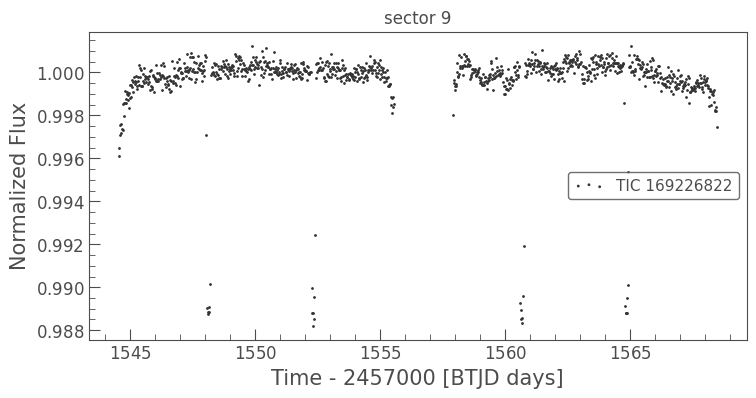

In [4]:
df.scatter()

In [6]:
df.save_CONAN_lcfile(bjd_ref = 2450000, folder="../data")

saved file as: ../data/WASP-127_S9.dat


## CONAN Brief

The CONAN has 3 major classes that are used to store information about the input files and setup fit configuration.

They are:
- `load_lightcurves()` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters. It contains methods to configure the LCs for fitting such as:

    - `lc_baseline()`
    - `get_decorr()`
    - `add_GP()`
    - `add_spline()`
    - `add_sinusoid()`
    - `supersample()`
    - `clip_outliers()`
    - `add_custom_LC_function()`
    - `planet_parameters()`
    - `phasecurve()`
    - `transit_depth_variation()`
    - `transit_timing_variation()`
    - `limb_darkening()`
    - `get_LDs()`
    - `Save_LCs()`
    - ...
    
    
- `load_rvs` : similar to above that are applicable to RVs
- `fit_setup` : object to setup sampling of the parameter space

These objects are then given as input to the `run_fit()` function to perform sampling and the outcome saved as a `result` object. 

## Setup light curve object

We will fit one Euler lightcurve and the tess sector 9 lightcurve

In [2]:
path = "../data/"     #path to the lightcurve files
lc_list  = ["lc6bjd.dat", "WASP-127_S9.dat"]

### load light curve into CONAN and visualize

In [3]:
lc_obj = CONAN.load_lightcurves( file_list     = lc_list,
                                  data_filepath = path,
                                  filters       = ["R","T"],
                                  wl            = [0.6, 0.8], #in microns, only used to plot depth differences
                                  nplanet       = 1)
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |None None         None    |  y    0    0    0    0    0    0    0|n    2 n  None           


lightcurves from filepath: ../data/
1 transiting planet(s)
Order of unique filters: ['R', 'T']

- **The lightcurve object** `lc_obj` holds information about the light curves (data and settings):

`Ssmp`: supersampling (for long cadence data)

`clip`: outlier clipping

`scl_col`: scaling the arrays in the columns of the data

`off`: whether to fit for an offset

`col{x}`: polynomial order in the columns x={0,3,4,5,6,7} of the data to  use for decorrelation

`sin`: include a sinusoid in the baseline model

`id`: light curve number 

`GP`: defined GP to model the baseline

`spline_config`: fit a spline to the baseline

**By default they are all deactivated**. We will define these different options in the following steps


We can inspect the light curve files which are stored as dictionary in `lc_obj._input_lc`. 

Use `pandas` just for nice print-out of the first 5 lines and see the assigned column names

In [4]:
pd.DataFrame(lc_obj._input_lc["lc6bjd.dat"]).head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8
0,8209.555598,1.007264,0.000705,2.43,4.48,1.20,15.11,284.40,45.0
1,8209.556263,1.006767,0.000704,0.52,2.49,1.20,15.71,284.47,45.0
2,8209.556931,1.007128,0.000704,0.46,2.78,1.20,15.02,284.95,45.0
3,8209.557602,1.007728,0.000705,1.63,1.94,1.20,15.46,283.68,45.0
4,8209.558277,1.005616,0.000697,1.94,1.78,1.19,15.98,285.25,45.0


In [5]:
pd.DataFrame(lc_obj._input_lc["WASP-127_S9.dat"]).head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8
0,8544.537364,0.996105,0.000231,1.0,1.0,1.0,1.0,1.0,1.0
1,8544.558198,0.996479,0.000230,1.0,1.0,1.0,1.0,1.0,1.0
2,8544.579031,0.997080,0.000230,1.0,1.0,1.0,1.0,1.0,1.0
3,8544.599865,0.997540,0.000230,1.0,1.0,1.0,1.0,1.0,1.0
4,8544.620698,0.997604,0.000229,1.0,1.0,1.0,1.0,1.0,1.0


Notice that `col3` to `col8` of the TESS data were automatically filled with ones since they were empty

##### Visualizing the data

The light curves can be plotted using the `plot()` method of the object.

By default this plots column 0 (time) against column 1 (flux) with column 3(flux err) as uncertainties. 

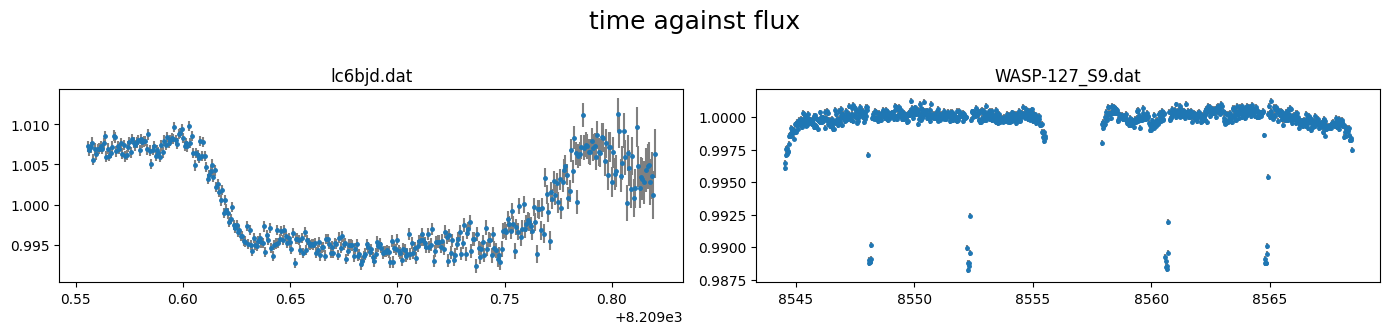

In [6]:
lc_obj.plot()

- **correlations** between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 against column 1 (flux)

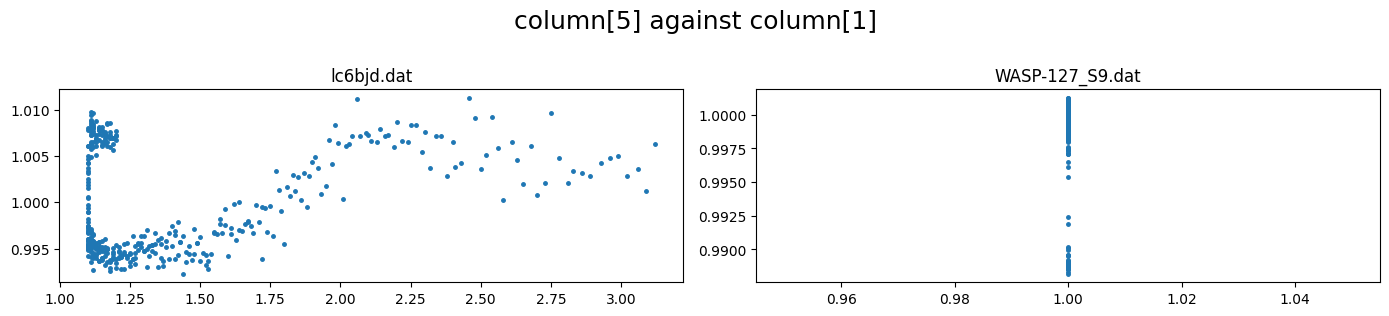

In [7]:
lc_obj.plot(plot_cols=(5,1))

### some data processing

##### clipping outlier points

 we can remove outliers from all or specific lcs. This uses a sliding median of specified `width` to discard points greater than `clip`$\times$ the M.A.D (median absoulte deviation). The clipped data is saved to the `lc_obj`. further analysis is performed on the clipped data

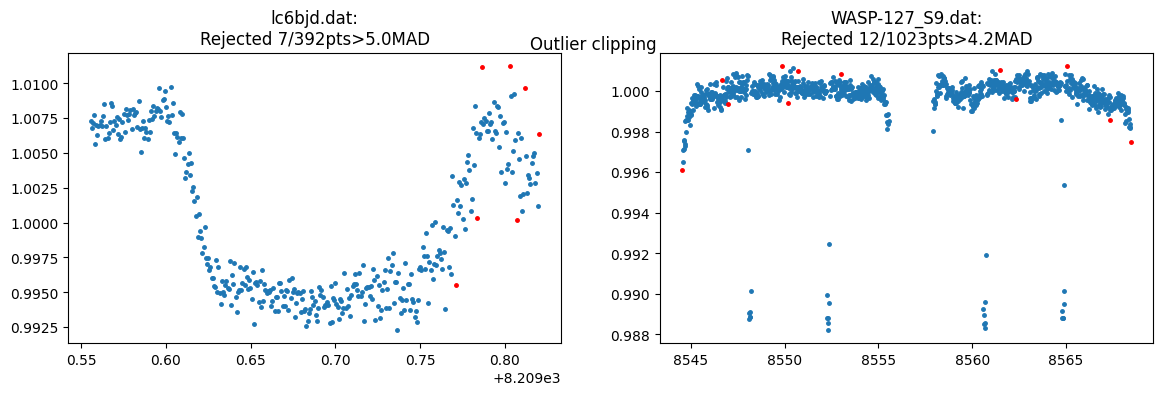

In [8]:
lc_obj.clip_outliers(lc_list="all", width=[11,5], clip=[5,4.2],show_plot=True)

##### rescaling data columns. 

This is useful for decorrelating the flux against the different columns. It is only performed on columns 3 and above whose values do not span zero. There are 3 methods to rescale the data: **"med_sub"**, **"rs0to1"**, **"rs-1to1"** which subtracts the median, rescales to [0-1], or rescales to [-1,1] respectively


In [9]:
lc_obj.rescale_data_columns(method=["med_sub","None"])

Rescaled data columns of lc6bjd.dat with method:med_sub
No rescaling for WASP-127_S9.dat


We can confirm that these operations have been written into `lc_obj`

In [10]:
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    0    0    0    0    0    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |None c1:W5C4.2n1  None    |  y    0    0    0    0    0    0    0|n    2 n  None           


lightcurves from filepath: ../data/
1 transiting planet(s)
Order of unique filters: ['R', 'T']

showing the **med_sub** has been used to scale the relevant columns of *lc6bjd.dat*, and the data have been clipped using **c{`column`}:W{`width`}C{`clip`}n{`iterations`}**

##### estimate of lightcurve statistics

For each loaded light curve, the `rms` and `jitter` are estimated from the data properties and stored in a list as:

In [11]:
print(f"{lc_obj._rms_estimate  = }")
print(f"{lc_obj._jitt_estimate = }")     

lc_obj._rms_estimate  = [0.0011117820828712038, 0.00028087567717406876]
lc_obj._jitt_estimate = [0.0003490563305132201, 0.00017317313538562336]


the **jitter** estimates the amount of extra noise to be quadratically added to the flux errorbars for them to be commensurate to the flux rms. For each lc, the log of this value is used as start value when fitting the log_jitter. The user can modify this list as required

the **rms_estimate** is used to define limits on the decorrelation parameters if not defined by user

### Setup Transit 

Parameters are defined in `CONAN` in 4 formats:
- **Fixed**:                  int/float e.g `q1` = 0.5
- **Normal prior**:           tuple of length 2 --> (mean, sigma) e.g. `rho_star` = (0.5, 0.03)
- **Uniform prior**:          tuple of length 3 --> (min, start, max) e.g. `Period` = (0, 0.5, 1) 
- **LogUniform prior**:       tuple of length 4 --> (min, start, max,'LU') e.g. `rho_star` = (0.01, 1, 100, 'LU')
- **truncated normal prior**: tuple of length 4 --> (min, max, mu, sigma) e.g `q1`=(0,1,0.2,0.1)


##### system parameters

We can get **system parameters** from the [NASA exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/)

In [12]:
from CONAN.get_files import get_parameters

sys_params = get_parameters(planet_name   ="WASP-127b", 
                            check_rhostar =True)  #result cached in the current working directory
sys_params

Getting system parameters from NASA exoplanet archive ...
rho_star to Tdur: 0.175718+/-0.002816
T14:              0.181370+/-0.000350
rho_star conversion to Tdur is consistent with literature T14 within 3 sigma


{'star': {'Teff': (5620.0, 85.0),
  'logg': (4.18, 0.01),
  'FeH': (-0.193, 0.014),
  'radius': (1.333, 0.027),
  'mass': (0.95, 0.02),
  'density': (0.569, 0.021)},
 'planet': {'name': 'WASP-127 b',
  'period': (4.17806203, 8.8e-07),
  'rprs': (0.10103, 0.00026),
  'mass': (0.1647, 0.0214),
  'ecc': (0.0, nan),
  'w': (nan, nan),
  'T0': (2456776.62124, 0.00023),
  'b': (0.29, 0.04),
  'T14': (0.18137, 0.00035),
  'aR': (7.81, 0.11),
  'K[m/s]': (22.0, 3.0)}}

##### Transit and RV parameters

The `sys_params` can be used to specify the priors for the planet's **transit and RV** parameters

Let's put the relevant planet parameters in a dictionary for convenience. The parameters are defined for **transit/occultation/phasecurve/rv**


In [13]:
t0  = sys_params["planet"]["T0"][0] - 2450000

planet_pars = dict( T_0           = (t0, 0.001),                           #normal prior
                    Period        = sys_params["planet"]["period"][0],     #fixed
                    rho_star      = sys_params["star"]["density"],         #normal pripr
                    Impact_para   = (0, sys_params["planet"]["b"][0], 1),  #uniform prior
                    RpRs          = (0.05, 0.108, 0.17),                   #uniform prior
                    Eccentricity  = 0,
                    omega         = 90,
                    K             = 0)

The `.planet_parameters()` method of `lc_obj` is called to define the parameters in `CONAN`. 
This method takes in the same parameter names as defined in `planet_pars` dictionary so we can load this directly

In [14]:
lc_obj.planet_parameters(**planet_pars)

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        y   	N(0.569,0.021)                     	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs                       y   	U(0.05,0.108,0.17)                 	#range[-0.5,0.5]
Impact_para                y   	U(0,0.29,1)                        	#range[0,2]
T_0                        y   	N(6776.621239999775,0.001)         	#unit(days)
Period                     n   	F(4.17806203)                      	#range[0,inf]days
[Eccentricity]/sesinw      n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega]/secosw             n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K                          n   	F(0)      

`rho_star` or `Duration` can be supplied. the user selection is given in square brackets. 

The same goes for `Eccentricity`–`omega` combination which can instead be `sesinw`–`secosw`

##### Limb darkening

- The `sys_params` can also be used to obtain priors on the **stellar limb darkening** from the phoenix stellar library.
`CONAN` uses the Kipping parameterization of the quadratic law defined as $q_1$ and $q_2$.


Filter names can be obtained from the [SVO filter service](http://svo2.cab.inta-csic.es/theory/fps/) with names such as `Spitzer/IRAC.I1` or a name shortcut such as `TESS`, `CHEOPS`,`kepler`. 


List of filter shortcut names can be obtained using:

In [15]:
lc_obj._filter_shortcuts

{'kepler': 'Kepler/Kepler.k',
 'tess': 'TESS/TESS.Red',
 'cheops': 'CHEOPS/CHEOPS.band',
 'wfc3_g141': 'HST/WFC3_IR.G141',
 'wfc3_g102': 'HST/WFC3_IR.G102',
 'sp36': 'Spitzer/IRAC.I1',
 'sp45': 'Spitzer/IRAC.I2',
 'ug': 'Geneva/Geneva.U',
 'b1': 'Geneva/Geneva.B1',
 'b2': 'Geneva/Geneva.B2',
 'bg': 'Geneva/Geneva.B',
 'gg': 'Geneva/Geneva.G',
 'v1': 'Geneva/Geneva.V2',
 'vg': 'Geneva/Geneva.V',
 'sdss_g': 'SLOAN/SDSS.g',
 'sdss_r': 'SLOAN/SDSS.r',
 'sdss_i': 'SLOAN/SDSS.i',
 'sdss_z': 'SLOAN/SDSS.z'}

we specify filters for the EULER and TESS data

In [16]:
# the filter names assigned to each data during lightcurve ingestion are:
lc_obj._filnames

array(['R', 'T'], dtype='<U1')

In [17]:
filts = ['sdss_r','tess']

In [18]:
print(f"\nGetting limb darkening parameters for filter {filts}")
q1, q2 = lc_obj.get_LDs( Teff = sys_params['star']['Teff'],
                        logg  = sys_params['star']['logg'],
                        Z     = sys_params['star']['FeH'],
                        filter_names=filts)



Getting limb darkening parameters for filter ['sdss_r', 'tess']
sdss_r    (R): q1=(0.4221, 0.0227), q2=(0.3963, 0.0145)
tess      (T): q1=(0.2973, 0.0148), q2=(0.3782, 0.0131)


In [19]:
print(f"{q1=}\n{q2=}")

q1=[(0.4221, 0.0227), (0.2973, 0.0148)]
q2=[(0.3963, 0.0145), (0.3782, 0.0131)]


 `q1`, `q2`  can then be passed to the `.limb_darkening()` method of `lc_obj`

In [20]:
lc_obj.limb_darkening(q1=q1, q2=q2)

# ============ Limb darkening setup ============================================================================= 
filters	fit	q1               	q2               
R      	y  	N(0.4221,0.0227) 	N(0.3963,0.0145) 
T      	y  	N(0.2973,0.0148) 	N(0.3782,0.0131) 


### Baseline and decorrelation parameters

The **baseline model** for each lightcurve in `lc_obj` object can be defined **manually** or **automagically**

##### Manually define baseline model:

We manually define the baseline model using the `.lc_baseline()` method of the `lc_obj`

Define baseline model parameters to fit for each light curve using the columns of the input data. `dcol0` refers to decorrelation setup for column 0, `dcol3` for column 3, and so on.

Each baseline decorrelation parameter (dcol{x}) should be a list of integers specifying the polynomial order for column {x} for each light curve. e.g. Given 2 input light curves as we have here, 

If one wishes to fit a 1st order trend in column 0 (time) to only the first and second lightcurve, then `dcol0` = [1, 1].

For the first lightcurve, we saw a strong correlation of the flux with column 5. We can fit this with a 2nd order term by setting `dcol5` = [2, 0]

In [21]:
lc_obj.lc_baseline( dcol0 = [1, 1], 
                    dcol5 = [2, 0], 
                    )

# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    1    0    0    2    0    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |None c1:W5C4.2n1  None    |  y    1    0    0    0    0    0    0|n    2 n  None           


- we can **add a spline** to the baseline of the TESS lc using the `.add_spline()` method 

Let's add a **spline** of `degree` 3 in time (`col0`) to the baseline model of the TESS data. A spline is fitted to consecutive `knot_spacing` chunks of the data. 

In [22]:
lc_obj.add_spline(  lc_list      = ["WASP-127_S9.dat"], 
                    par          = ["col0"], 
                    degree       = [3], 
                    knot_spacing = [2])



# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    1    0    0    2    0    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |None c1:W5C4.2n1  None    |  n    1    0    0    0    0    0    0|n    2 n  c0:d3k2        


Notice that the addition of a spline to the TESS data sets `off="n"` for that lc. that's because the spline model already contains an offset term thereby making the `off` here unnecessary

 - Let's also **supersample** the long cadence TESS data by a factor of 30 (`x30.0`). This subdivides each exposure time by 30 to attain a sampling of ~1 minute. We can use a supersampling facore of `x15` to acheive 2 minute sampling.

In [23]:
lc_obj.supersample( lc_list   = ["WASP-127_S9.dat"], 
                    ss_factor = 30)

Supersampling WASP-127_S9.dat with exp_time=30.0mins each divided into 30 subexposures
# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    1    0    0    2    0    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |x30  c1:W5C4.2n1  None    |  n    1    0    0    0    0    0    0|n    2 n  c0:d3k2        


##### automagically define baseline model:

Figuring out the best combination of decorrelation parameters for each lightcurve can be quite difficult requiring to perform several fits to the data and somehow select the fit with the best decorrelation. `CONAN` implements a method to determine the best baseline model for each input lightcurve

The `.get_decorr()` function of the `lc_obj` can be used to automatically determine the best decorrelation parameters to use. This is a least-squares fit (using `lmfit` package) to the data and comparing the Bayesian Information Criterion, **BIC**, when adding decorrelation parameters (see [forward selection regression method](https://www.statisticshowto.com/forward-selection/) )

To do this, we would like take into account the transit/occultation/phasecurve when peforming the least-squares fit. So defined parameter priors in `planet_pars` are also used

Now run `.get_decorr()` to get decorrelation parameters by loading the `planet_pars` dictionary and limb darkening priors `q1`,`q2`.

The function uses columns 0,3,4,5,6,7 to construct a polynomial trend model. The decorr parameters are labelled `Ai`,`Bi` for 1st & 2nd order coefficients in column **i**. 

`spline`,`supersampling`, and `GP` configurations are also used for decorrelation, if defined before running `.get_decorr()`

By default, decorrelation parameters that reduce the BIC by 5 (i.e delta_BIC = -5) are iteratively selected. This implies bayes_factor = $e^{(-0.5 \times -5)}$ = 12 or more is required for a parameter to be selected.


getting decorr params for lc01: lc6bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:710.68, pars:['offset', 'A6', 'B5', 'A5']

getting decorr params for lc02: WASP-127_S9.dat (spline=True, sine=False, gp=False, s_samp=True, jitt=0.0ppm)
BEST BIC:2495.81, pars:['B0', 'A0']

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    0    0    0    2    1    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |x30  c1:W5C4.2n1  None    |  n    2    0    0    0    0    0    0|n    2 n  c0:d3k2        
Total number of baseline parameters: 6


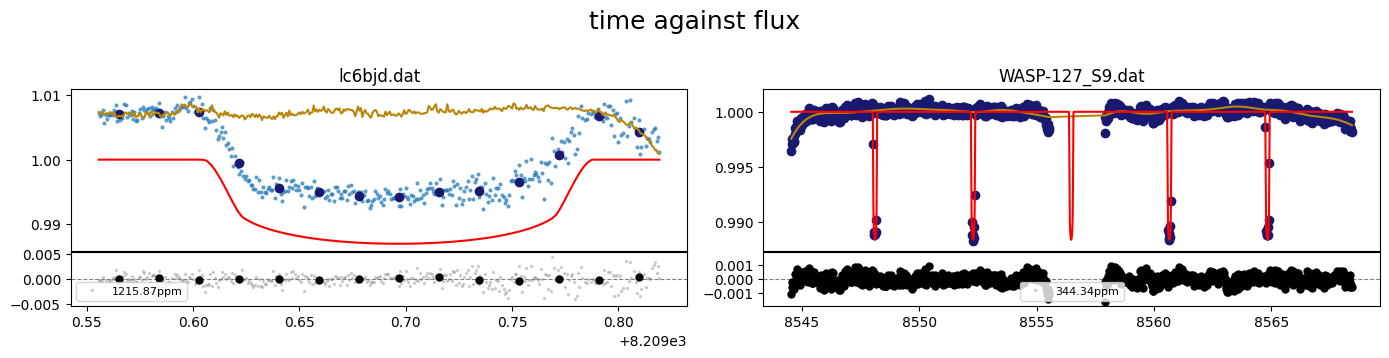

In [24]:
decorr_res = lc_obj.get_decorr( **planet_pars,
                                q1             = q1,  
                                q2             = q2,
                                exclude_cols   = [7],       #columns to exclude from decorrelation e.g [3,4]
                                enforce_pars   = [],       #decorr parameters to enforce e.g ["A5",B6]
                                delta_BIC      = -5,
                                setup_baseline = True,
                                show_steps     = False,
                                )

the output `decorr_res` is a list that holds the `lmfit` result for each lc. Explore each element to see the result

In [25]:
decorr_res

We can use the `.plot()` method again to visualize the fit quality across the different decorrelation axis by setting `show_decorr_model=True`

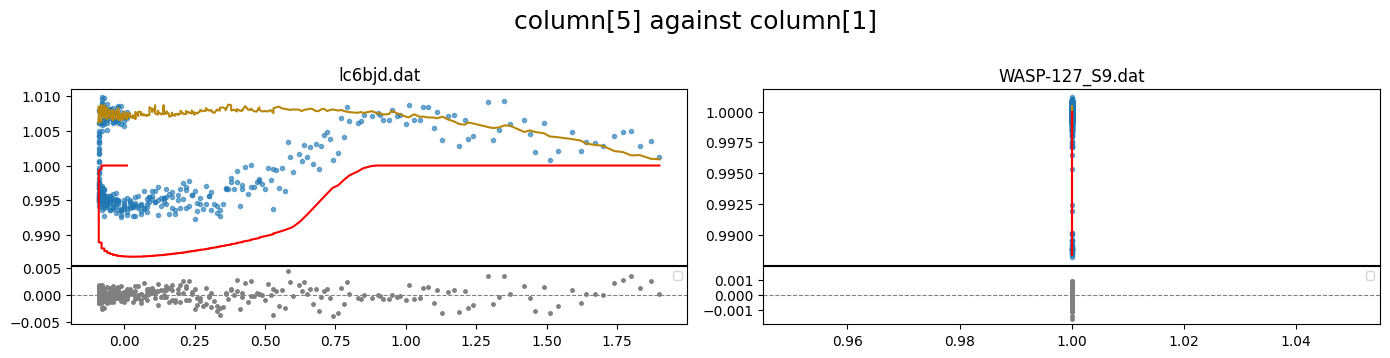

In [26]:
lc_obj.plot(plot_cols=(5,1), show_decorr_model=True)

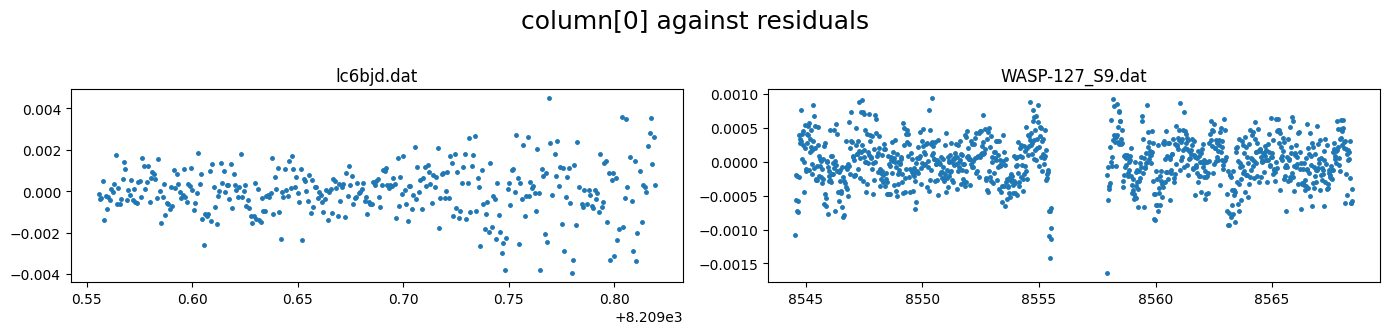

In [27]:
lc_obj.plot(plot_cols=(0,"res"), show_decorr_model=True)

We see that the residuals from the TESS lightcurve fit still has **correlated structures** that the spline fit did **not do very well** in capturing

We can remove the spline fitting for `TESS` and instead use a `Celerite` GP for the baseline


In [28]:
lc_obj.add_spline(None)

No spline



We can use the `.print()` method to print out the current configuration of the different sections of the `lc_obj`

To see the current baseline model configuration, set section to "lc_baseline"

In [29]:
lc_obj.print(section="lc_baseline")

# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    0    0    0    2    1    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |x30  c1:W5C4.2n1  None    |  n    2    0    0    0    0    0    0|n    2 n  None           


Notice that the `spline_config` has been set to None for the TESS data

### Define GP 

The `.add_GP()` method of `lc_obj` is used to setup GP for the lightcurves - selecting the GP package to use, the kernels and priors on the hyperparameters.

GP package `gp_pck` can be one of **["ge","ce","sp"]** for George, Celerite, or Spleaf. 

GP kernel options are:

- [George](https://george.readthedocs.io/en/latest/user/kernels/):  ['mat32', 'mat52', 'exp', 'cos', 'expsq', 'exps2', 'qp', 'rquad']
- [Celerite](https://celerite.readthedocs.io/en/stable/python/kernel/): ['mat32', 'exp', 'cos', 'sho', 'qp_ce']
- [Spleaf](https://obswww.unige.ch/~delisle/spleaf/doc/_autosummary/spleaf.term.html): ['mat32', 'mat52', 'exp', 'cos', 'sho', 'expsq', 'exps2', 'qp', 'qp_sc', 'qp_mp']


see details of the kernel definitions on the [github wiki](https://github.com/titans-ge/CONAN/wiki/Gaussian-Processes-with-CONAN)
    
 Up to 2 kernels of the same package can be used for each lc and then their *sum* or *product* can be taken.

2 GP hyperparameters are to be specified: `amplitude` corresponds to the standard deviation of the noise process in *ppm*, and `lengthscale` corresponds to the characteristic timescale of the noise process.
            


In [30]:
lc_obj.add_GP(lc_list     = ["WASP-127_S9.dat"],
              par         = ["col0"],
              kernel      = ["mat32"],
              amplitude   = [(20,400, 4000)],    #in ppm, uses log-uniform prior    
              lengthscale = [(0.007,0.4, 5)],    #in days, also log-uniform prior
              gp_pck      = ["ce"]               ## gp package celerite
              )       

# ============ Input lightcurves, filters baseline function =======================================================
name            flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc6bjd.dat      R   0.6  |None c1:W11C5n1   med_sub |  y    0    0    0    2    1    0    0|n    1 n  None           
WASP-127_S9.dat T   0.8  |x30  c1:W5C4.2n1  None    |  n    2    0    0    0    0    0    0|n    2 ce None           
# ============ Photometry GP properties (start newline with name of * or + to Xply or add a 2nd gp to last file) =========
name/filt       kern  par    h1:[Amp_ppm]       h2:[len_scale1]    h3:[Q,η,α,b]       h4:[P]       
WASP-127_S9.dat mat32 col0   LU(20,400,4000)    LU(0.007,0.4,5)    None               None        


##### filter dependent 

In [31]:
lc_obj.transit_depth_variation()
lc_obj.phasecurve()
lc_obj.contamination_factors()


# ============ ddF setup ========================================================================================
Fit_ddFs	dRpRs           	div_white
n       	U(-0.5,0,0.5)   	n  
R: modeling only occultation signal
T: modeling only occultation signal
# ============ Phase curve setup ================================================================================ 
flt D_occ[ppm]         Fn[ppm]            ph_off[deg]  A_ev[ppm]       f1_ev[ppm]    A_db[ppm]       pc_model
R   F(0)               None               None         F(0)            F(0)          F(0)            cosine  
T   F(0)               None               None         F(0)            F(0)          F(0)            cosine  
# ============ contamination setup (give contamination as flux ratio) ======================================== 
flt	contam_factor
R  	F(0)                
T  	F(0)                


### visualize all light curve setup or different sections

In [32]:
lc_obj.print("limb_darkening")   

# ============ Limb darkening setup ============================================================================= 
filters	fit	q1               	q2               
R      	y  	N(0.4221,0.0227) 	N(0.3963,0.0145) 
T      	y  	N(0.2973,0.0148) 	N(0.3782,0.0131) 


In [ ]:
 #no argument prints all lightcurve setup
lc_obj.print()

## Setup RV

The RV setup is similar to the LC

In [34]:
path ="../data/"
rv_list = ["rv1.dat","rv2.dat"]    #rv data in km/s

In [35]:
rv_obj = CONAN.load_rvs(file_list     = rv_list, 
                         data_filepath = path,
                         rv_unit       ='km/s',
                         nplanet       = 1,
                         lc_obj        = lc_obj      #load lc_obj if planning to update planet parameters
                        )
rv_obj

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        
rv2.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        


rvs from filepath: ../data/
1 planet(s)

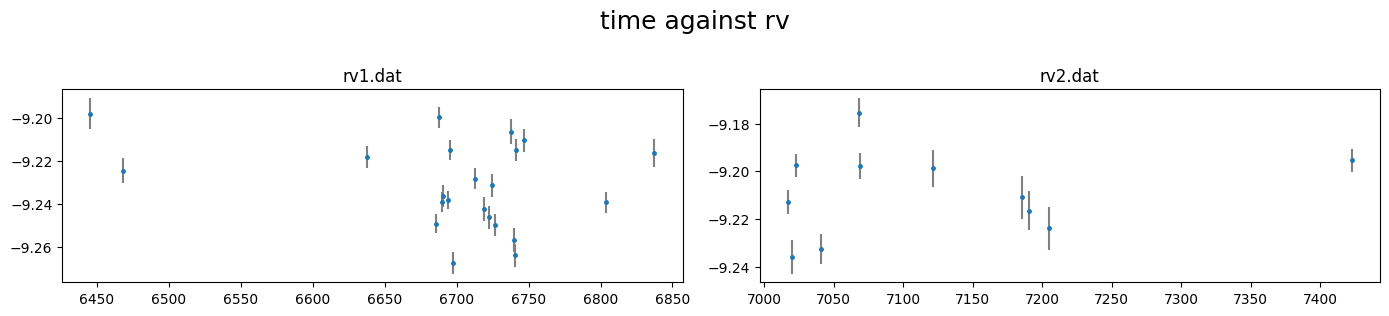

In [36]:
rv_obj.plot()

In [37]:
pd.DataFrame(rv_obj._input_rv["rv1.dat"]).head()

,col0,col1,col2,col3,col4,col5
0,6445.543512,-9.197929,0.007287,-0.042628,8.150114,34.211741
1,6468.462797,-9.224495,0.005818,-0.036697,8.192204,33.604743
2,6637.825616,-9.218248,0.005210,-0.035312,8.191037,33.948751
3,6685.729323,-9.249265,0.004468,-0.034618,8.264129,33.534162
4,6687.689793,-9.199722,0.005097,0.000972,8.288035,33.353229


In [38]:
rv_obj.rescale_data_columns()

Rescaled data columns of rv1.dat with method:med_sub
Rescaled data columns of rv2.dat with method:med_sub


We can update the RV parameters incase not defined in `lc_obj.planet_parameters()` 

e.g. add a prior for the RV semi-amplitude `K`

In [39]:
rv_obj.update_planet_parameters(K=(0,10e-3,50e-3))   

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        y   	N(0.569,0.021)                     	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs                       y   	U(0.05,0.108,0.17)                 	#range[-0.5,0.5]
Impact_para                y   	U(0,0.29,1)                        	#range[0,2]
T_0                        y   	N(6776.621239999775,0.001)         	#unit(days)
Period                     n   	F(4.17806203)                      	#range[0,inf]days
[Eccentricity]/sesinw      n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega]/secosw             n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K                          y   	U(0,0.01,0

### Baseline and decorrelation

- similar to lightcurves, we can manually specify the rv baseline model using the `.rv_baseline()` method

In [40]:
rv_obj.rv_baseline( dcol0 = None,
                    dcol3 = None,
                    dcol4 = None,
                    dcol5 = None,
                    gamma = [(-9.232,0.1), (-9.21,0.1)],
                    gp    = "n")

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.232,0.1) 
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.21,0.1)  


- or we can use the `.get_decorr()` method to find the best decorrelation 


getting decorr params for rv01: rv1.dat (jitt=0.00km/s)

BEST BIC:76.55, pars:['B0', 'A3', 'A4']

getting decorr params for rv02: rv2.dat (jitt=0.00km/s)

BEST BIC:14.02, pars:[]
Setting-up rv baseline model from result
# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   2    1    1    0|   0 n  None            | N(-9.229240663522978,0.1)
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.210554832957529,0.1)


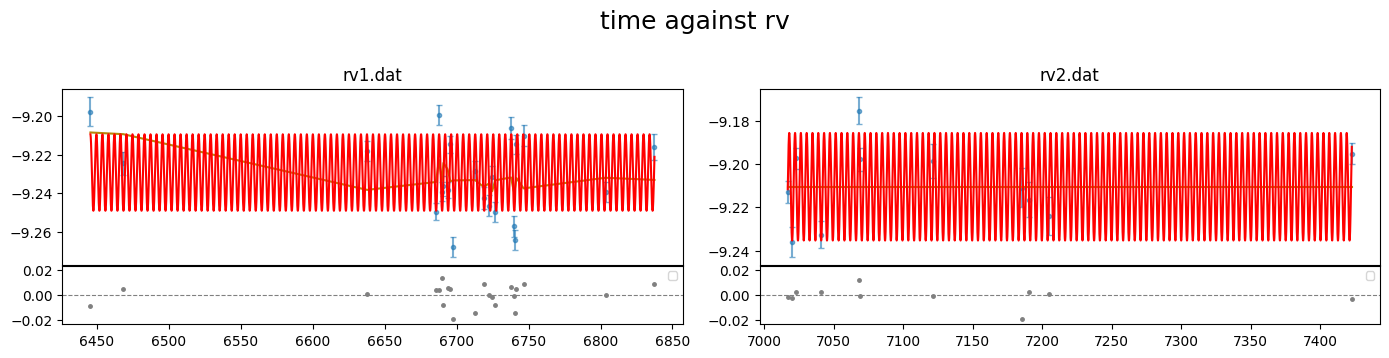

In [41]:
rvdecorr_res= rv_obj.get_decorr(T_0     = planet_pars["T_0"][0],
                                Period  = planet_pars["Period"],
                                K       = (0,22e-3,100e-3),       #km/s
                                gamma   = (-9.21,0.1),            #km/s
                                delta_BIC = -3)

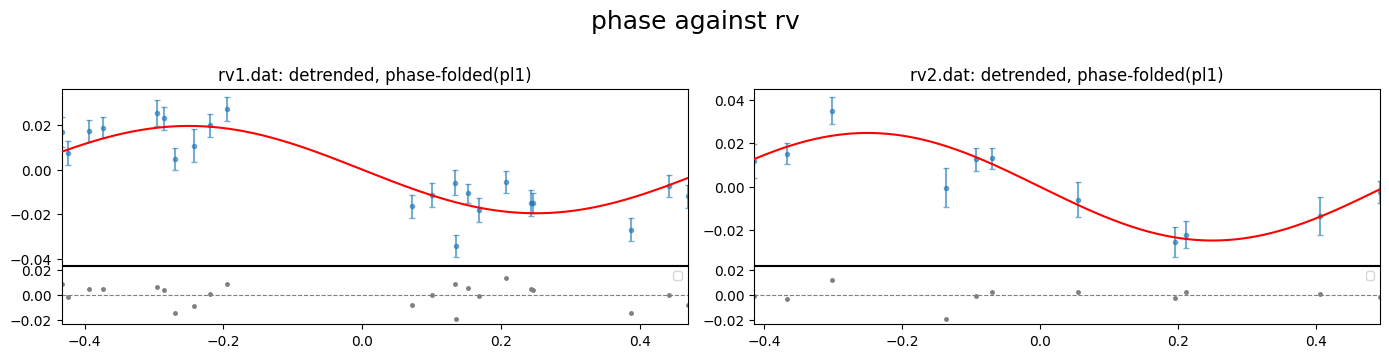

In [42]:
rv_obj.plot(plot_cols         = (0,1,2),
            show_decorr_model = True, 
            detrend           = True, 
            phase_plot        = 1 )

investigate the reduced chi-square of the fits

In [43]:
rvdecorr_res[0].redchi, rvdecorr_res[1].redchi

(3.593688666537606, 1.0248418035114055)

the high `redchi` of the first RV data implies that it needs a more complicated baseline model or the errorbars are underestimated. we will fit for an RV jitter for each data in the global fit.

- if there are no RV for the setup, it can be turned off using:

In [44]:
# rv_data = CONAN.load_rvs()

## Setup Sampling

finally to setup the `fit_obj` which is used to configure the fitting.

We can specify values for the stellar mass or radius to be used to convert parameter results to physical values. These values are not used in the fit, only for the post-fit conversion. We can also take the values from our NASA archive `sys_params` dictionary

In [45]:
sys_params["star"]["radius"], sys_params["star"]["mass"]

((1.333, 0.027), (0.95, 0.02))

In [46]:
fit_obj = CONAN.fit_setup(  R_st            = sys_params["star"]["radius"],
                            M_st            = sys_params["star"]["mass"],
                            par_input       = "Rrho",
                            apply_LCjitter  = "y", 
                            apply_RVjitter  = "y",
                            LCbasecoeff_lims= "auto", 
                            RVbasecoeff_lims= "auto")

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.333,0.027)
Mass_[Msun]    N(0.95,0.02)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho


setup sampling using the `.sampling()` method of `fit_obj`. Note that the sampling of the parameter space can be done with `emcee` or `dynesty`. The default is `dynesty`

In [47]:
fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=100)

# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    100 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])            auto 
RVjitter_lims(auto/[lo,hi])               auto 
LCbasecoeff_lims(auto/[lo,hi])            auto 
RVbasecoeff_lims(auto/[lo,hi])            auto 
Light_Travel_Time_correction(y/n)         n


## Export configuration

All configuration can be exported to a `config.dat` file that allows to reproduce all steps and eventually run the fit

In [57]:
CONAN.create_configfile(   lc_obj   = lc_obj, 
                            rv_obj   = rv_obj, 
                            fit_obj  = fit_obj,
                            filename = 'wasp127_lcrv_config.dat'
                            )

configuration file saved as wasp127_lcrv_config.dat


In [1]:
# uncomment lines below to reload objects from config file

import CONAN
lc_obj, rv_obj, fit_obj = CONAN.load_configfile(   configfile  = 'wasp127_lcrv_config.dat', 
                                                    # init_decorr = True, 
                                                    # verbose     = True
                                                    )

## Sampling

Finally perform the **fitting** which returns a result object `result_obj` that holds the chains of the mcmc and allows subsequent plotting.

The result of the fit is saved to a user-defined folder (default = 'output'). If a fit result already exists in this folder, it is loaded to the `result_obj`

To include `offset` in the fit for all LCs, uncomment the following line

In [2]:
# lc_obj._fit_offset = ["y"]*lc_obj._nphot

In [ ]:
result = CONAN.run_fit(lc_obj      = lc_obj,
                        rv_obj      = rv_obj,
                        fit_obj     = fit_obj,
                        out_folder  = "result_wasp127_lcrv_fit",
                        rerun_result=True);   #rerun result even to use existing chains to remake plots

## Results

In [4]:
import CONAN
import matplotlib.pyplot as plt
import numpy as np
from CONAN.utils import bin_data, phase_fold

In [5]:
result =CONAN.load_result(folder="result_wasp127_lcrv_fit")
result

['lc'] Output files, ['WASP-127_S9_lcout.dat', 'lc6bjd_lcout.dat'], loaded into result object
['rv'] Output files, ['rv1_rvout.dat', 'rv2_rvout.dat'], loaded into result object


Object containing posterior from emcee/dynesty sampling                 
Parameters in chain are:
	 ['rho_star', 'T_0', 'RpRs', 'Impact_para', 'K', 'R_q1', 'R_q2', 'T_q1', 'T_q2', 'lc1_logjitter', 'lc2_logjitter', 'rv1_gamma', 'rv1_jitter', 'rv2_gamma', 'rv2_jitter', 'lc1_off', 'lc1_A5', 'lc1_B5', 'lc1_A6', 'lc2_off', 'rv1_A0', 'rv1_B0', 'rv1_A3', 'rv1_A4', 'GPlc2_Amp1_col0', 'GPlc2_len1_col0']                 

use `plot_chains()`, `plot_burnin_chains()`, `plot_corner()` or `plot_posterior()` methods on selected parameters to visualize results.

In [6]:
result.plot_chains(pars = ['T_0', 'RpRs', 'Impact_para', 'K'], figsize=(7,4));

chains are not available for dynesty sampler. instead see dynesty_trace_*.png plot in the output folder.


In [7]:
%matplotlib inline

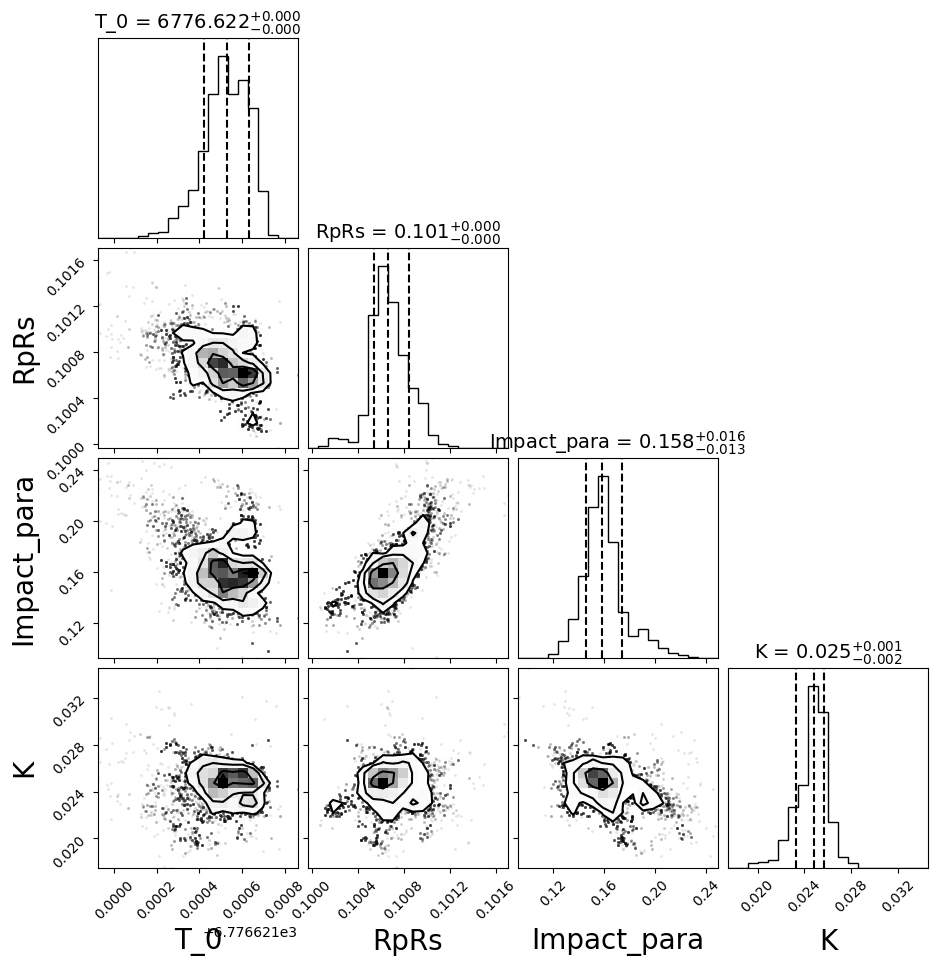

In [10]:
fig = result.plot_corner(pars = ['T_0', 'RpRs', 'Impact_para', 'K']);

### Make customised plots from results

#### LCs

In [11]:
result.lc.names

['lc6bjd.dat', 'WASP-127_S9.dat']

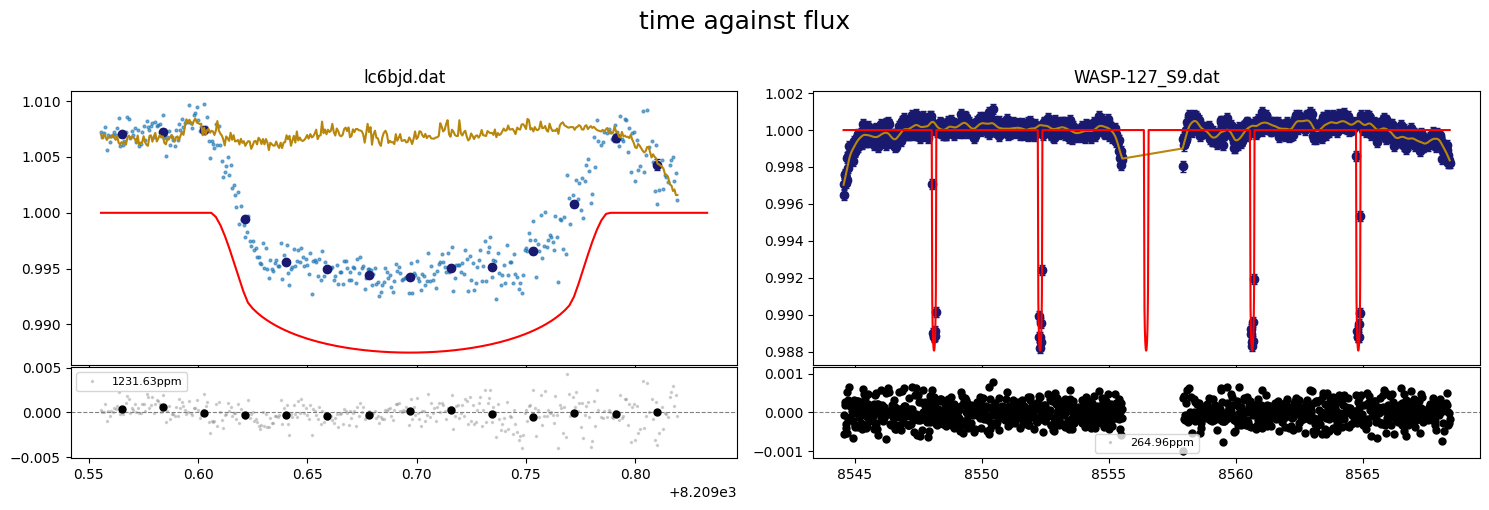

In [40]:
fig = result.lc.plot_bestfit(figsize=(15,5))

In [52]:
# fig.supxlabel("Time [BJD - 2450000]", x=0.5,y=-0.01)
# fig.axes[0].set_ylabel("Relative flux",fontsize=14)
# fig.axes[1].set_ylabel("O - C", fontsize=14)
# fig.suptitle("")
# fig.savefig("../../../joss/wasp-127.png", dpi=300, bbox_inches='tight')
# fig

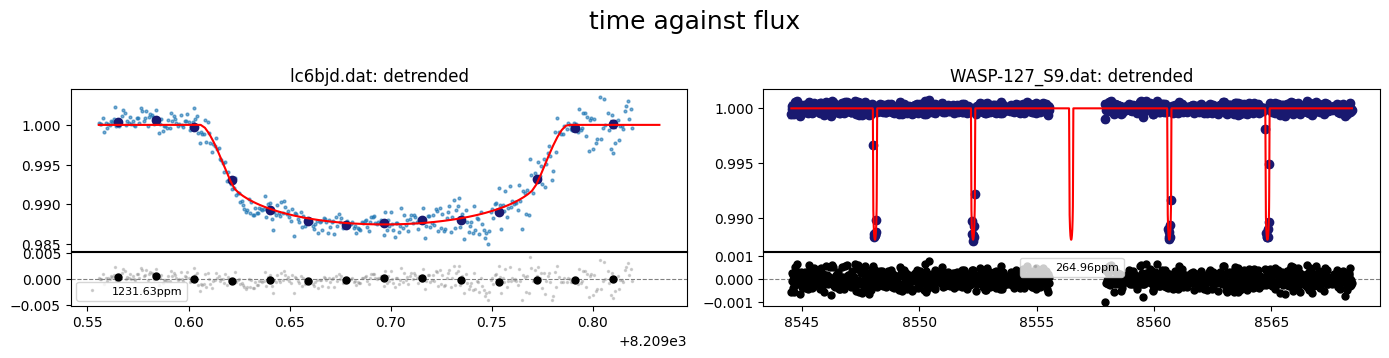

In [14]:
fig = result.lc.plot_bestfit(detrend=True)

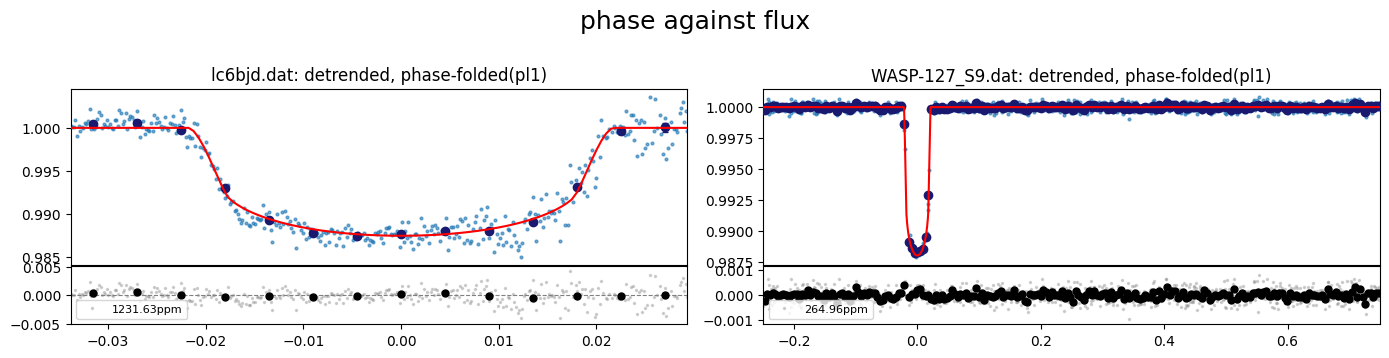

In [15]:
# Plot the best fit with phase folding with period of planet 1
fig = result.lc.plot_bestfit(detrend=True, phase_plot=1)

In [16]:
#load output data files for the lc fits
lc1data = result.lc.outdata['lc6bjd.dat']
lc2data = result.lc.outdata['WASP-127_S9.dat']

lc1data.keys()

Index(['time', 'flux', 'error', 'full_mod', 'base_para', 'base_sine',
       'base_spl', 'base_gp', 'base_total', 'transit', 'det_flux', 'residual',
       'phase'],
      dtype='object')

In [17]:
#evaluate LC model on a smoother time array
t_sm  = np.linspace(lc1data["time"].min(), lc1data["time"].max(), 1000)
lcmod = result.lc.evaluate(file="lc6bjd.dat",time=t_sm,return_std = True)

phases = phase_fold(t=t_sm, per=result.params.P, t0=result.params.T0, phase0=-0.5)

#sort
srt    = np.argsort(phases)

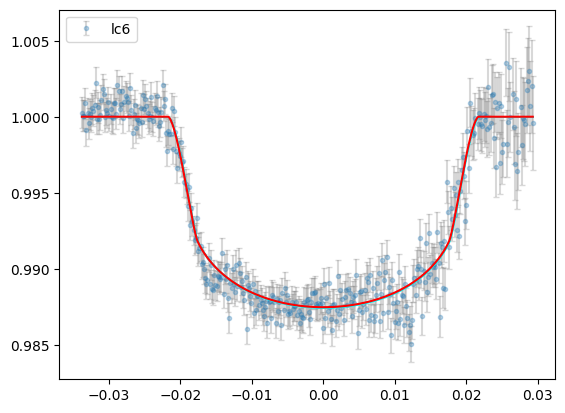

In [18]:
plt.errorbar(lc1data["phase"],lc1data["det_flux"],lc1data["error"],
                fmt="o",ms=3,ecolor="gray",alpha=0.3,capsize=2,label="lc6")

plt.plot(phases[srt], lcmod.planet_model[srt],"r",zorder=4)
plt.fill_between(phases[srt],lcmod.sigma_low[srt], lcmod.sigma_high[srt], color="cyan",zorder=3)

plt.legend()

In [19]:
#evaluate LC model on a smoother time array
t_sm   = np.linspace(lc2data["time"].min(), lc2data["time"].max(), 1000)
lc2mod = result.lc.evaluate(file='WASP-127_S9.dat',time=t_sm,return_std=True)

phases = phase_fold(t=t_sm, per=result.params.P, t0=result.params.T0, phase0=-0.5)
#sort
srt    = np.argsort(phases)

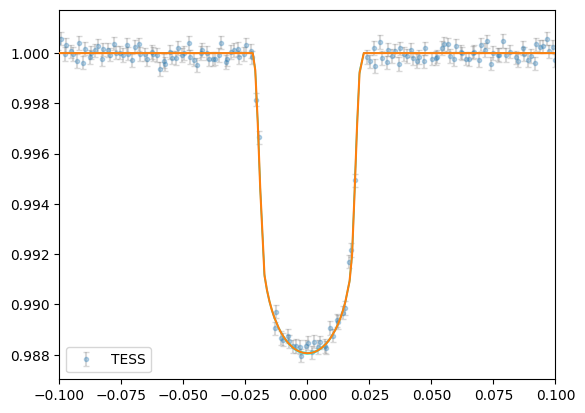

In [20]:
plt.errorbar(lc2data["phase"],lc2data["det_flux"],lc2data["error"],
             fmt="o",ms=3,ecolor="gray",alpha=0.3,capsize=2,label="TESS")

plt.plot(phases[srt], lc2mod.planet_model[srt],zorder=4)
plt.fill_between(phases[srt],lc2mod.sigma_low[srt], lc2mod.sigma_high[srt], color="cyan",zorder=3)

plt.xlim([-0.1,0.1])

plt.legend()

#### RVs

In [21]:
result.rv.names

['rv1.dat', 'rv2.dat']

In [22]:
%matplotlib inline

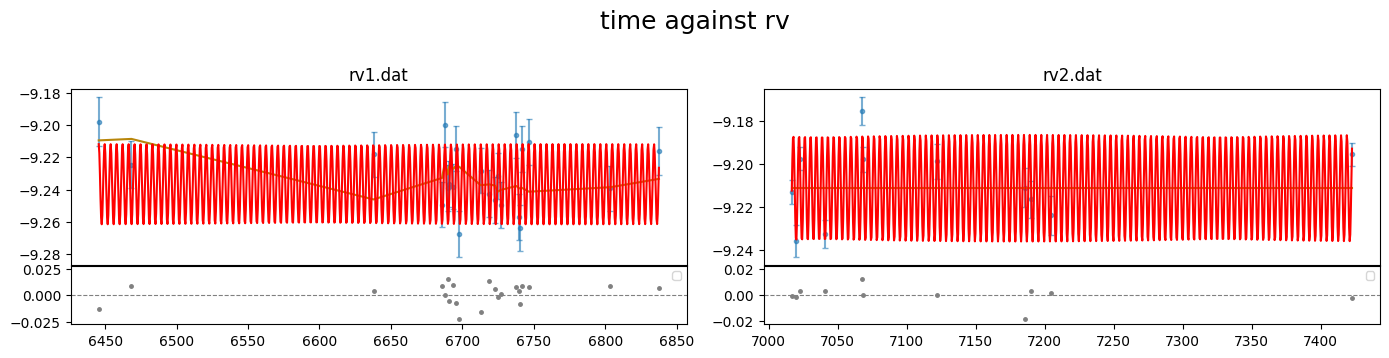

In [34]:
fig = result.rv.plot_bestfit((0,1,2))

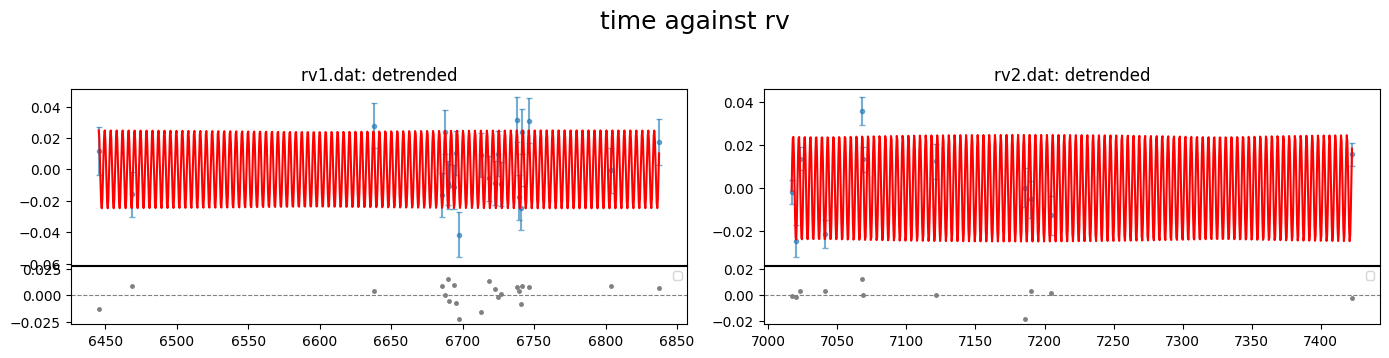

In [35]:
fig = result.rv.plot_bestfit((0,1,2),detrend=True)

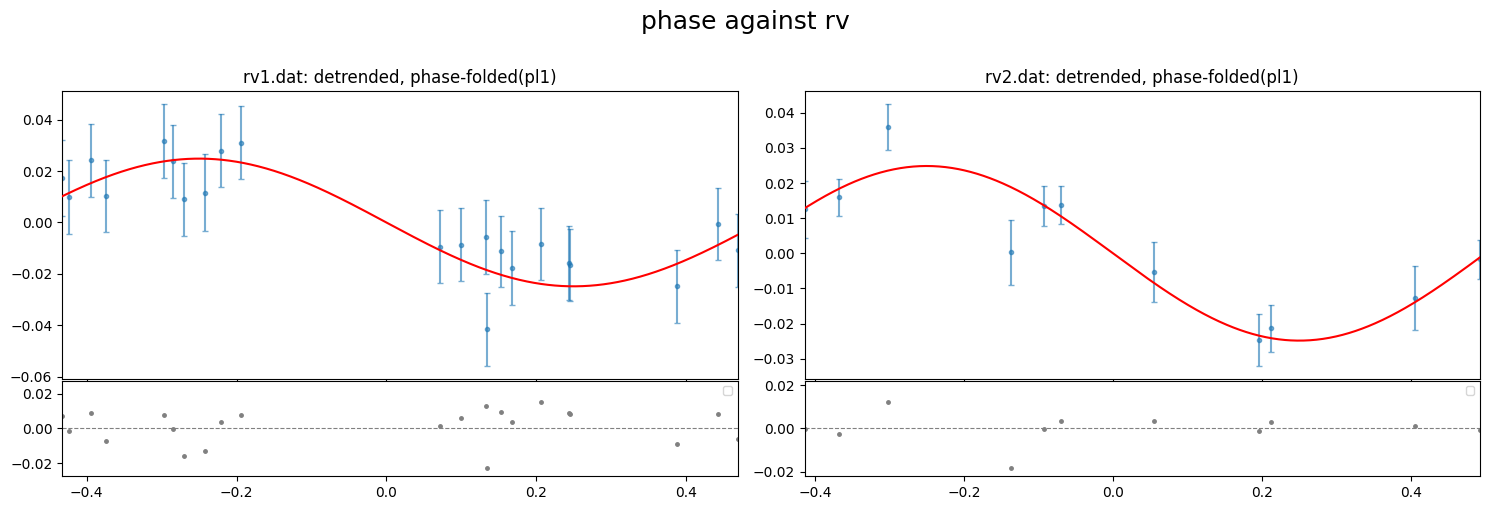

In [47]:
fig = result.rv.plot_bestfit((0,1,2), detrend=True, phase_plot=1, figsize=(15,5))

In [53]:
# #plot for paper
# fig.supxlabel("Phase", x=0.5,y=-0.005)
# # fig.supylabel("RV [km/s]", y=0.5, x=-0.005)
# fig.axes[0].set_ylabel("RV [km/s]", fontsize=14)
# fig.axes[1].set_ylabel("O - C", fontsize=14)
# fig.suptitle("", fontsize=16)
# # for i in range(len(fig.axes)):
# #     fig.axes[i].set_title(fig.axes[i].get_title().replace("detrended, ",""))
# fig.savefig("../../../joss/wasp-127rv.png", dpi=300, bbox_inches='tight')
# # fig

In [49]:
#load output data files for the rv fits
rv1data = result.rv.outdata['rv1.dat']
rv2data = result.rv.outdata['rv2.dat']

rv1data.keys()

Index(['time', 'RV', 'error', 'full_mod', 'base_para', 'base_spl', 'base_gp',
       'base_total', 'Rvmodel', 'det_RV', 'gamma', 'residual', 'phase'],
      dtype='object')

In [50]:
#evaluate RV model on a smoother time array
t_sm  = np.linspace(rv1data["time"].min(), rv1data["time"].max(), 1000)
rvmod = result.rv.evaluate(file="rv1.dat",time=t_sm, return_std=True)

phases = phase_fold(t=t_sm, per=result.params.P, t0=result.params.T0, phase0=-0.5)
#sort
srt    = np.argsort(phases)

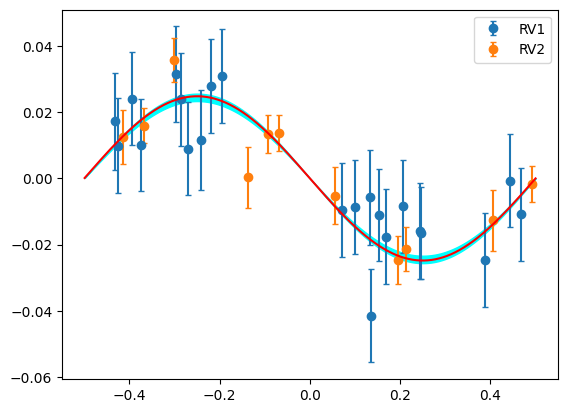

In [51]:
plt.errorbar(rv1data["phase"],rv1data["det_RV"],rv1data["error"],fmt="o",capsize=2,label="RV1")
plt.errorbar(rv2data["phase"],rv2data["det_RV"],rv2data["error"],fmt="o",capsize=2,label="RV2")

plt.plot(phases[srt], rvmod.planet_model[srt],"r",zorder=5)

plt.fill_between(phases[srt],rvmod.sigma_low[srt], rvmod.sigma_high[srt], color="cyan")


plt.legend()